# Knysh-Korkolis sampler

In [2]:
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
from black_it.loss_functions.msm import MethodOfMomentsLoss
from black_it.search_space import SearchSpace
from numpy.random import default_rng
from numpy.typing import NDArray

from black_it.samplers.knysh_korkolis import KnyshKorkolisSampler


In [3]:
# seed management
_seed = -1
def seed():
    global _seed
    _seed += 1
    return _seed

Text(0, 0.5, 'value')

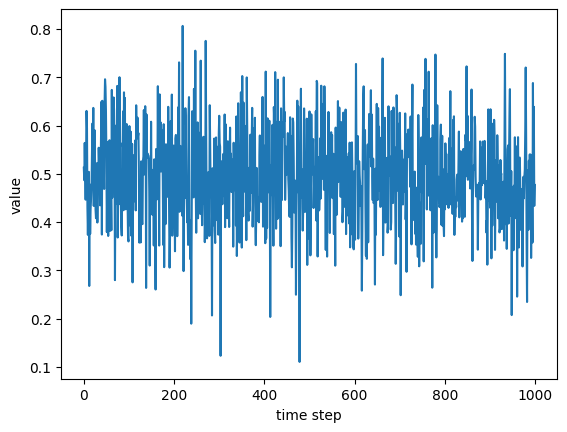

In [4]:
def NormalMV(theta: Sequence[float], N: int, seed: int) -> NDArray[np.float64]:
    """Normal samples with adjustable mean and variance."""
    rng = default_rng(seed)
    y = rng.normal(theta[0], theta[1], N)
    return np.atleast_2d(y).T

true_params = [0.5, 0.1]  # in general these are not known!
real_data = NormalMV(true_params, 1000, seed())
plt.plot(real_data[:, 0])
plt.xlabel("time step")
plt.ylabel("value")

In [5]:
# define a 2-dimensional grid of possible parameter values between 0 and 1.
param_grid = SearchSpace(
    parameters_bounds=np.array([[0, 1], [0, 1]]).T,
    parameters_precision=[0.01, 0.01],
    verbose=False,
)

loss_function = MethodOfMomentsLoss()

In [6]:
dims = len(true_params)
nb_iterations = 40
nb_ensemble = 1
N = 1000
batch_size = 5
nb_exploration_batches = 20
max_samples = batch_size * (nb_iterations - nb_exploration_batches)

sampler = KnyshKorkolisSampler(batch_size=batch_size, random_state=seed(), nb_exploration_batches=nb_exploration_batches, max_samples=max_samples, verbose=True, rho0=1.0)

points = np.zeros((0, param_grid.dims))
losses = np.array([])


for i in range(nb_iterations):
    print("Iteration ", i + 1)
    current_batch = sampler.sample(param_grid, points, losses)
    current_losses = []
    for point in current_batch:
        outputs = []
        for ensemble in range(nb_ensemble):
            outputs.append(NormalMV(point, N, seed()))
        outputs = np.array(outputs)
        outputs = outputs.reshape(nb_ensemble, -1, 1)
        loss = loss_function.compute_loss(outputs, real_data)
        current_losses.append(loss)
    points = np.concatenate([points, current_batch])
    losses = np.concatenate([losses, current_losses])


Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19


/Users/aldoglielmo/DRTA_code/black-it/black_it/utils/time_series.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s, k = skew(time_series), kurtosis(time_series)  # pylint: disable=invalid-name
/Users/aldoglielmo/miniconda3/envs/black-it/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


Iteration  20
Iteration  21
Using radius 0.05641895835477563
Using radius 0.05585471206162554
Using radius 0.055295940303471895
Using radius 0.05474248027066873
Using radius 0.0541941737467279
Iteration  22
Using radius 0.05365086688207656
Using radius 0.05311240997809639
Using radius 0.05257865728073679
Using radius 0.05204946678303744
Using radius 0.05152470003593503
Iteration  23
Using radius 0.05100422196676487
Using radius 0.0504879007049007
Using radius 0.04997560741400539
Using radius 0.04946721613039176
Using radius 0.04896260360701693
Iteration  24
Using radius 0.04846164916265438
Using radius 0.047964234535807414
Using radius 0.047470243742943743
Using radius 0.046979562940645585
Using radius 0.04649208029128175
Iteration  25
Using radius 0.04600768583181816
Using radius 0.045526271345391486
Using radius 0.04504773023527616
Using radius 0.04457195740087921
Using radius 0.04409884911539902
Iteration  26
Using radius 0.043628302904783686
Using radius 0.04316021742762203
Using r

In [7]:
best = points[np.argmin(losses)]
print("Best parameters        :", points[np.argmin(losses)], np.min(losses))

Best parameters        : [0.48 0.08] 0.08818807937002197


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_10225/3978248302.py:6: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(true_params[0], true_params[1], marker="x", s=500, facecolor="red", edgecolors='black')
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_10225/3978248302.py:9: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(best[0], best[1], marker="x", s=500, facecolor="yellow", edgecolors='black')


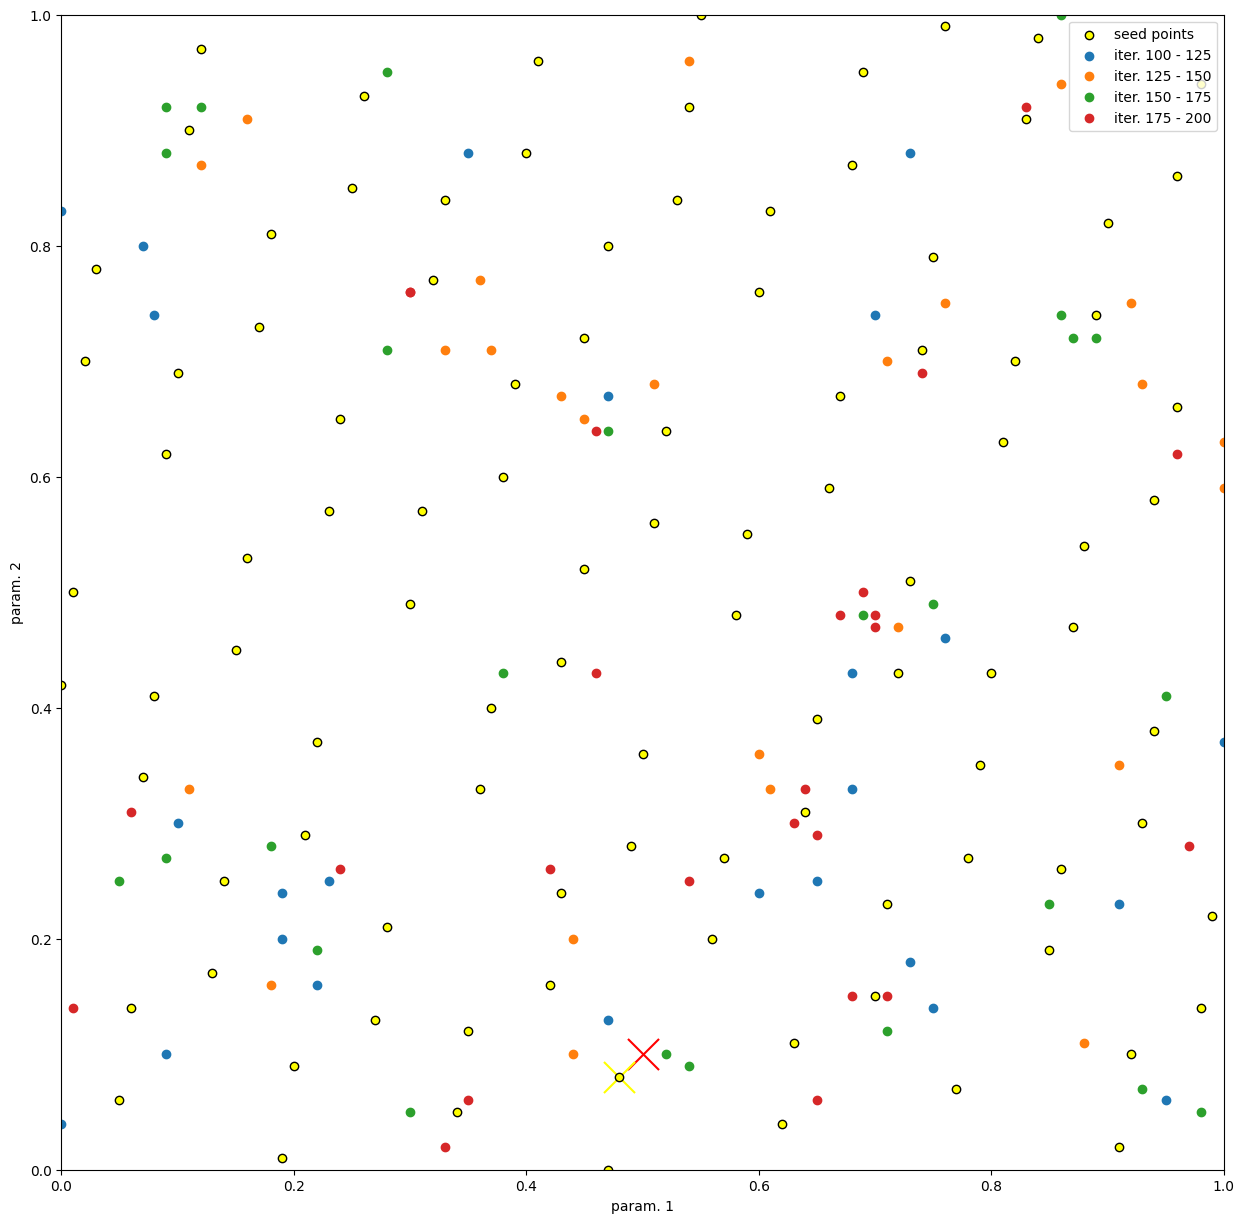

In [9]:
# plot both seed points and exploitation points
fig = plt.figure(figsize=(15, 15))
axes = plt.axes()

# plot true parameters
plt.scatter(true_params[0], true_params[1], marker="x", s=500, facecolor="red", edgecolors='black')

# plot best found parameters
plt.scatter(best[0], best[1], marker="x", s=500, facecolor="yellow", edgecolors='black')

# plot seed points
plt.scatter(points[:nb_exploration_batches * batch_size, 0], points[:nb_exploration_batches * batch_size, 1], marker="o", facecolor="yellow", edgecolors='black', label="seed points")

# plot other points
nb_batches_per_scatter = 5
for i in range(nb_exploration_batches, nb_iterations, nb_batches_per_scatter):
    plt.scatter(
        points[i * batch_size : (i + nb_batches_per_scatter) * batch_size, 0],
        points[i * batch_size : (i + nb_batches_per_scatter) * batch_size, 1],
        label="iter. " + str(i * batch_size) + " - " + str((i + nb_batches_per_scatter) * batch_size),
    )

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("param. 1")
plt.ylabel("param. 2")
plt.legend()